# Simple powder pattern refinement

This describs a basic single powder pattern refinement using MStruct Python API. It assumes an intial model is saved in an xml-format. One can use e.g. [MStruct GUI](https://github.com/xray-group/mstruct-gui) to create one. It shows how to:
- get calculated pattern
- fix and unfix parameters
- run a simple LSQ refinement
- access parameters, change their values and recalculate the powder pattern
- export data and the final refined model

Last modified: 2024-02-20, Author: Zdenek

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import libMStruct as mst
print(mst.version())

0.15.8-python3.11


### Load data, crystal and microstructure model

The whole MStruct project can loaded from an `*.xml` file.

#### Generating an MStruct xml-file

- If you have `*.imp`, set the number of refinement iteractions to zero and run MStruct binary program. It will produce an `xray.xml`.
- If you have neither `*.imp` or MStruct `*.xml` file, try to use [MStruct GUI](https://github.com/xray-group/mstruct-gui) to create one. ;-) 

Crystal(s) and PowderPattern including data and microstructure model will be loaded in MStruct/ObjCryst global registry after calling `XMLCrystFileLoadAllObject.`

In [3]:
mst.XMLCrystFileLoadAllObject('data/tio2-film-stress1-start.xml')

### Powder pattern

Get a reference to the PowderPattern object from the global RefinableObj registry by calling `GetPowderPattern` function with the PowderPattern object name as its single argument.

In [4]:
pattern = mst.GetPowderPattern('pattern0')

Prepare PowderPattern data for computation, (optionally) fit scale factor and fianlly get a calcuated pattern.

In [5]:
pattern.Prepare()
pattern.FitScaleFactorForRw() # try to comment this line
ycalc = pattern.GetCalc()

### Plotting

We do not have a nice PowderPattern Python wrapper as in ObjCryst so we nned a simple plotting routine. Feel free to customize. :-)

In [6]:
def ms_plot(pattern, xl=(), yl=(), figsize=()):
    if figsize not in [(), None, []]:
        plt.figure(figsize = figsize)

    x = pattern.GetPowderPatternX()
    yobs = pattern.GetPowderPatternObs()
    ycalc = pattern.GetCalc()
    ydiff = yobs - ycalc
    
    lindx = np.ones_like(x, dtype=bool)
    
    if xl not in [(), None, []]:
        plt.xlim(xl)
        lindx = np.logical_and(x>=xl[0]*np.pi/180., x<=xl[1]*np.pi/180.)
    if yl not in [(), None, []]:
        plt.xlim(yl)

    plt.plot(180.0/np.pi *x[lindx], np.sqrt(yobs[lindx]), 'r*', ms=2)
    plt.plot(180.0/np.pi *x[lindx], np.sqrt(ycalc[lindx]), 'b-')
    plt.plot(180.0/np.pi *x[lindx], np.sqrt(np.abs(ydiff[lindx]))*np.sign(ydiff[lindx]), 'g-')
    plt.ylabel('sqrt( Intensity )')
    plt.xlabel('2Theta (deg)');

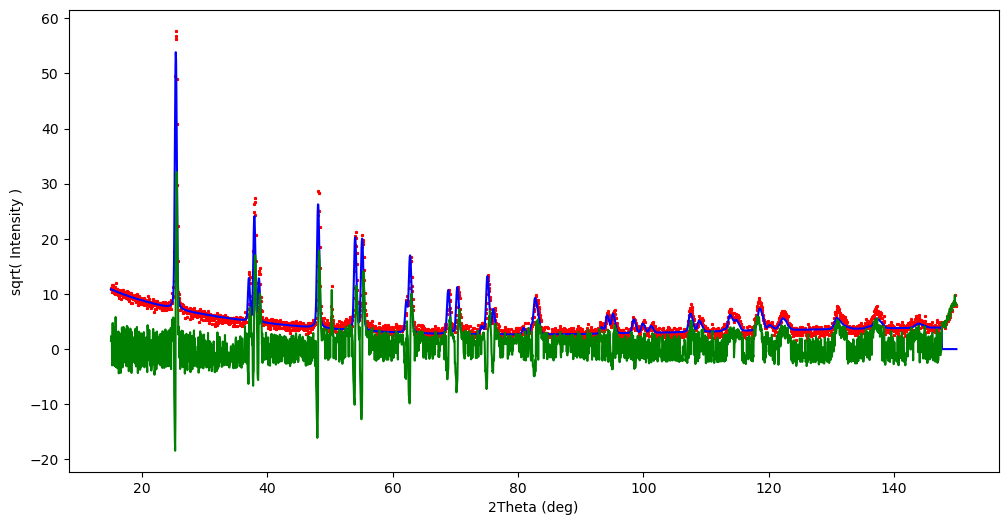

In [7]:
ms_plot(pattern, figsize=(12,6))

Plot a detail.

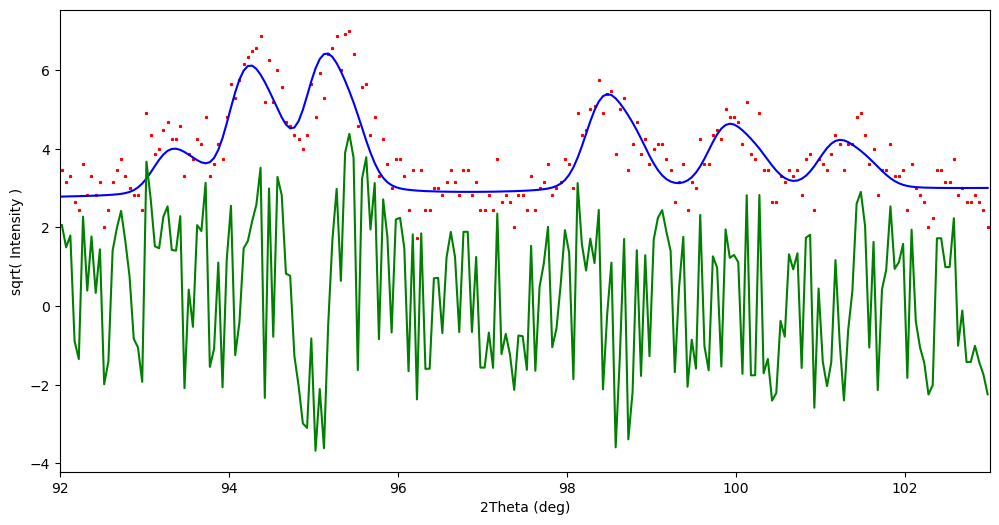

In [8]:
ms_plot(pattern, figsize=(12,6), xl=(92,103))

The peak positions are slightly off.

### Refinement

In [9]:
# Create MStruct & ObjCryst LSQ optimization object for the Powderpattern
# and intialize refinement parameters list. (connect LSQ and pattern together)
lsq = mst.LSQ()

lsq.SetRefinedObj(obj=pattern, LSQFuncIndex=0, init=True, recursive=True)
lsq.AddRefinableObj(obj=pattern) # MStruct LSQ is a compbination of ObjCryst LSQ and ObjCryst Optimization

If we check `pattern` we do not see all refinable parameters.

In [10]:
pattern.Print()

This is why we have to work with a recursively compiled refinable object provided by LSQ.

In [11]:
lsq.PrepareRefParList(copy_param=False)  # must be called first !
lsqr = lsq.GetCompiledRefinedObj()
lsqr.Print()

### Fix parameter

We can see the *Stress* parameter is zero and not fixed. Let's fix it.

In [12]:
lsq.SetParIsFixed(parName="Stress", fix=True)

Auxilliary function `refine` for fitting ... parameters refinement. It includes everything that we would need to repeat always.

In [13]:
def refine(lsq, nbCycle=-10, silent=False):
    # Refinement
    lsq.PrepareRefParList(copy_param=False)  # must be called first !
    # lsq.GetCompiledRefinedObj().Print()
    lsqr = lsq.GetCompiledRefinedObj()
    lsqr.PrepareForRefinement()
    lsq.Refine(nbCycle=nbCycle, useLevenbergMarquardt=True, silent=silent, # use negative nbCycle to allow refinement stop after convergence
               callBeginEndOptimization=True, minChi2var=0.001) # note: this may take a while

In [14]:
refine(lsq, nbCycle=-20, silent=False)

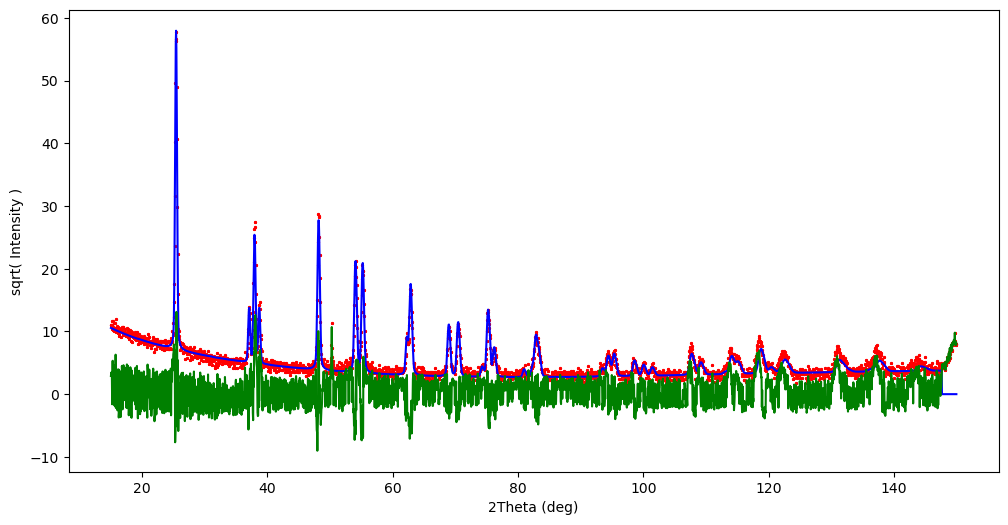

In [15]:
ms_plot(pattern, figsize=(12,6))

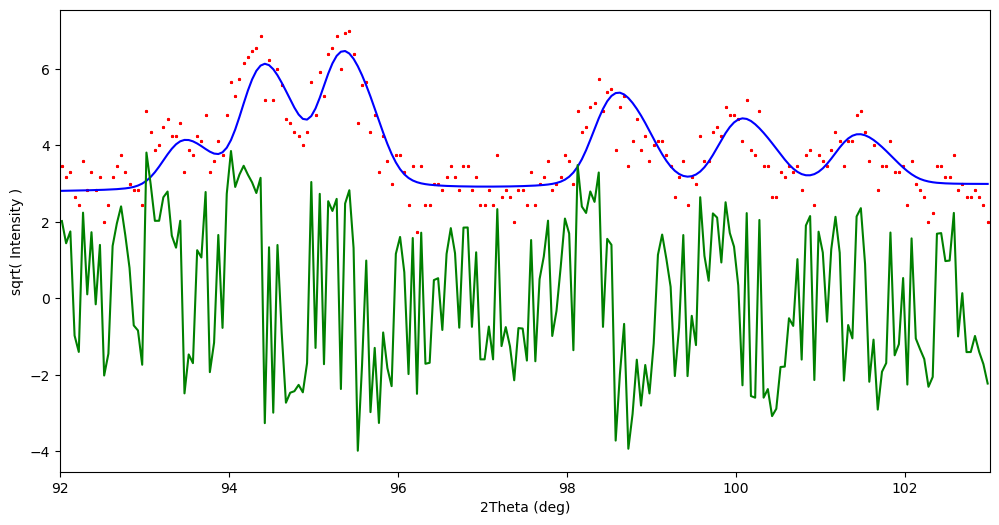

In [16]:
ms_plot(pattern, figsize=(12,6), xl=(92,103))

Let's unfix the *Stress* parameter and refinement again.

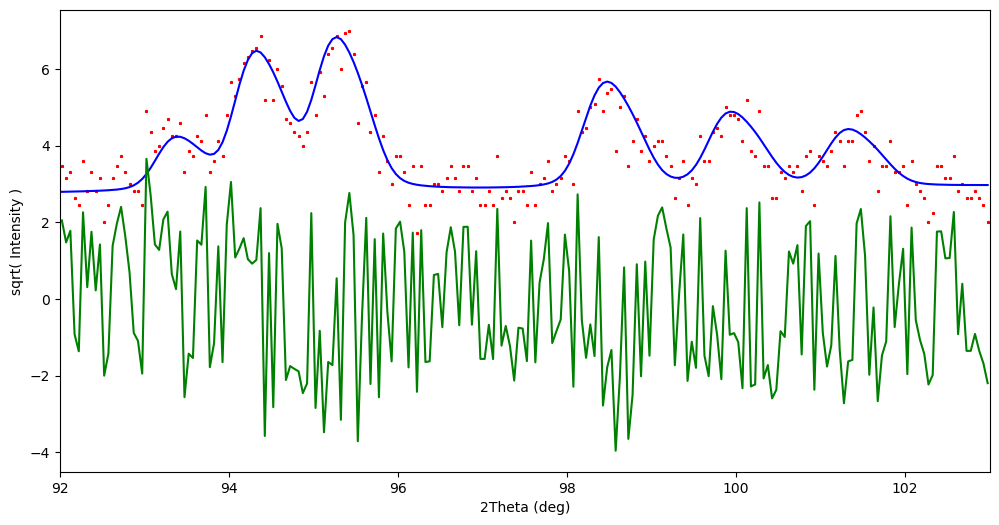

In [17]:
lsq.SetParIsFixed(parName="Stress", fix=False)
refine(lsq, nbCycle=-20, silent=True)
lsq.PrintRefResults()
ms_plot(pattern, figsize=(12,6), xl=(92,103))

So we see the GoF and the peak positions are better.

### Parameter value

In [18]:
name = 'Stress'
print('%s = %.3f (GPa)' % (name, lsqr.GetPar(name).value,))

Stress = 0.293 (GPa)


Let's set it much higher (10x) and see how it affects the powder pattern.

It is visible that mainly the peaks above $2\Theta > 98^\circ$ are sensitive to it.

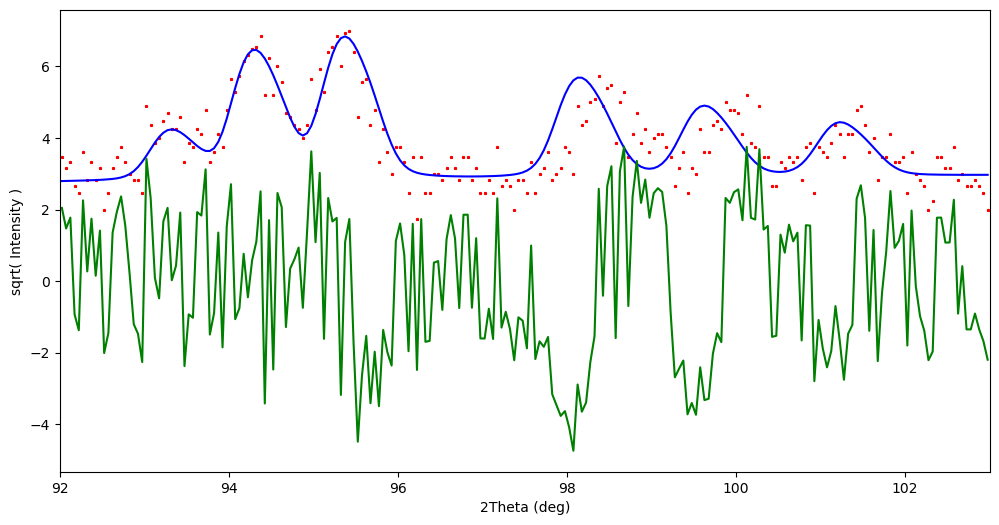

In [19]:
lsqr.GetPar('Stress').value = 3.0 # try positive and engative values
ms_plot(pattern, figsize=(12,6), xl=(92,103))

### Extended prameter name

One can use also a global MStruct function returning parameters from the global MStruct & ObjCryst registry with so called *composed extended parameter name*, e.g. `stressCorrAnatase:Stress`.

In [20]:
mst.GetPar('stressCorrAnatase:Stress').value = 0.0

simple_name = 'Stress'
print('%s = %.3f (GPa)' % (simple_name, lsqr.GetPar(simple_name).value,))

Stress = 0.000 (GPa)


Refine it again.

In [21]:
refine(lsq, nbCycle=-20, silent=True)
lsq.PrintRefResults()

### Saving powder pattern

One can always get the observed and calcuated data as numpy arrays as it is illustrated in the `ms_plot` function.

A native MStruct function `SavePowderPattern` writing data in a multi-column format is available too ... mainly for convenience.

In [22]:
pattern.SavePowderPattern('pattern.dat')

### Saving xml-file

One may like to saved the final model with refined parameters in the MStruct xml-format using the global `XMLCrystFileSaveGlobal` function.

*Note: This will export all MStruct objects loaded and created in this Python session. Even those not explicitely used!*

In [23]:
mst.XMLCrystFileSaveGlobal('final-ex1.xml')